source https://colab.research.google.com/github/tensorflow/hub/blob/r0.1/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb

In [0]:
!pip install -q --upgrade "tensorflow>=1.7" tensorflow-hub


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import re
import seaborn as sns

In [4]:
tf.__version__

'1.7.0'

# Universal Sentence Encoder

## Getting started

In [7]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

#Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")

messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  
  message_embeddings = session.run(embed(messages))
  
  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.016987282782793045, -0.008949815295636654, -0.0070627182722091675, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.03531332314014435, -0.025384284555912018, -0.007880025543272495, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [0.01879097707569599, 0.045365191996097565, -0.02001088112592697, ...]



## Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as 
inner product of the encodings

In [0]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
    corr,
    xticklabels=labels,
    yticklabels=labels,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")
  
def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages})
  plot_similarity(messages_, message_embeddings_, 90)
  

### Similarity Visualized

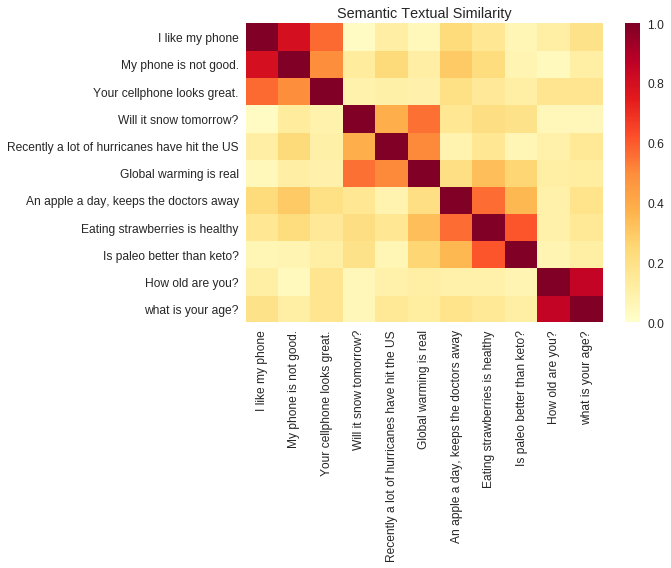

In [17]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  
  run_and_plot(session, similarity_input_placeholder, messages, similarity_message_encodings)

## Evaluation: Semantic Textual Similarity Benchmark

### Download data

In [0]:

import scipy
import math

def load_sts_dataset(filename):
  sent_pairs = []
  with tf.gfile.GFile(filename, "r") as f:
    for line in f:
      ts = line.strip().split("\t")
      # (sent_1, sent_2, similarity_score)
      sent_pairs.append((ts[5], ts[6], float(ts[4])))
      
  return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
  sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmar.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)
  
  sts_dev = load_sts_dataset(
    os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
  sts_test = load_sts_dataset(
    os.path.join(
      os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))
  
  return sts_dev, sts_test

sts_dev, sts_test = download_and_load_sts_data()
  

### Build Evaluation Graph

In [0]:
text_a = sts_dev['sent_1'].tolist()
text_b = sts_dev['sent_2'].tolist()
dev_scores = sts_dev['sim'].tolist()

sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1))
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2))
sim_scores = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)

### Evaluate Sentence Embeddings

In [22]:
def run_sts_benchmark(session):
  emba, embb, scores = session.run(
    [sts_encode1, sts_encode2, sim_scores],
    feed_dict={
        sts_input1: text_a,
        sts_input2: text_b
    })
  return scores

with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  
  scores = run_sts_benchmark(session)
  
  
pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.7513779772819759
p-value = 9.743625041468064e-273
